In [41]:
import sbi
import pickle
import torch
import numpy as np
from sbi.analysis import conditional_pairplot, pairplot
from sbi.utils import BoxUniform
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../arco_sims/adaptive_box_posteriors/")
import bounds

In [64]:
with open("../../../arco_sims/adaptive_box_posteriors/89_49992413252944133_0.02.pickle", "rb") as handle:
    posterior = pickle.load(handle)

posterior = posterior.set_default_x(torch.zeros(13))

In [65]:
samples = posterior.sample((10_000,))

In [66]:
all_bounds_ = bounds.bounds_
bounds_ = all_bounds_["89", "49992413252944133"]

In [67]:
upper_ = np.asarray(list(bounds_["max"].values()))
lower_ = np.asarray(list(bounds_["min"].values()))
gt_ = np.asarray(list(bounds_["value"].values()))

In [68]:
prior = BoxUniform(torch.as_tensor(lower_, dtype=torch.float32), torch.as_tensor(upper_, dtype=torch.float32))

In [69]:
samples[0]

tensor([ 7.5601e+01,  1.2107e-02,  1.4346e+02,  4.5355e-03,  4.1962e+02,
         1.8093e-02,  3.9215e-03,  1.8183e-04,  2.6606e-04,  1.6235e-01,
         2.2862e-03,  3.6531e-03,  9.1848e-04,  1.5116e-01,  5.0457e-02,
         8.9753e-02,  6.0462e-02,  1.5177e-02,  2.6122e+00,  3.4085e+00,
         3.0275e-03,  3.9111e-03,  9.2429e-05,  5.5692e-02, -1.9937e-04,
        -4.3750e-04,  2.3156e-01, -1.4060e+00,  1.2781e+00,  8.0905e-01,
         3.1351e-05,  4.3781e-05,  3.7344e-05,  3.3480e-05,  2.0223e+00])

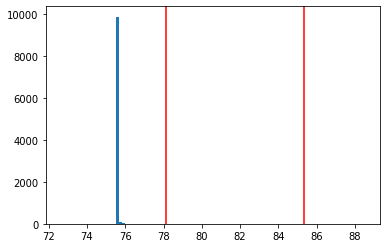

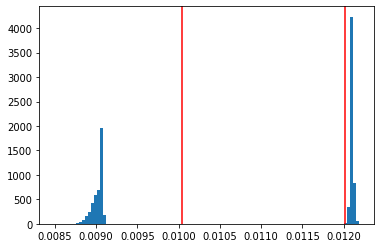

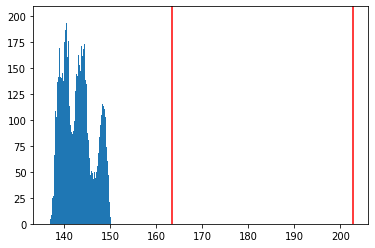

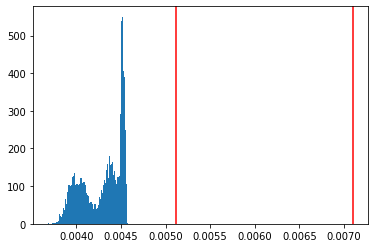

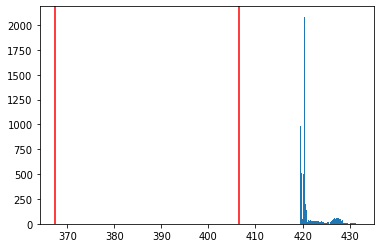

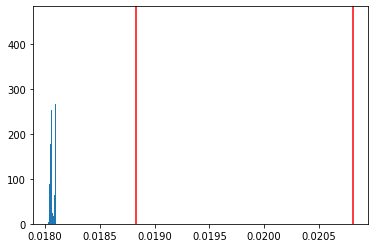

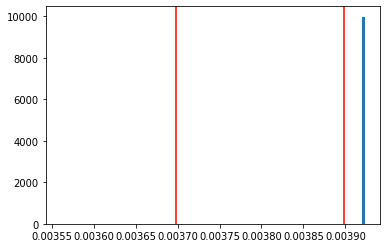

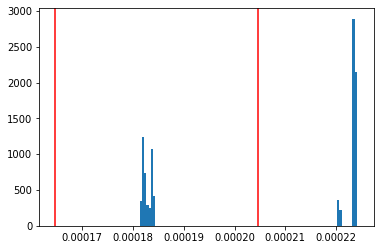

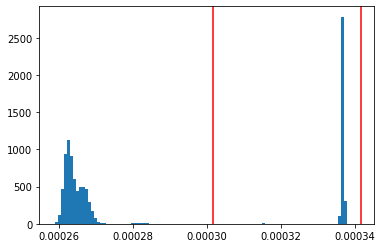

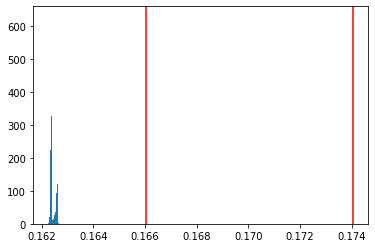

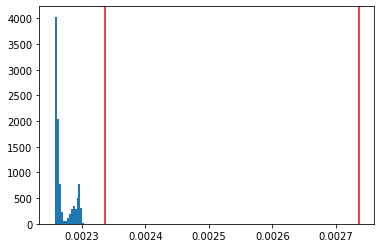

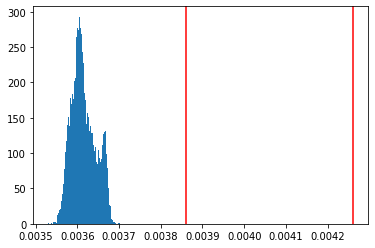

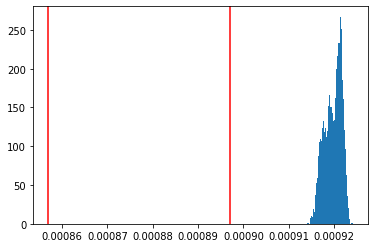

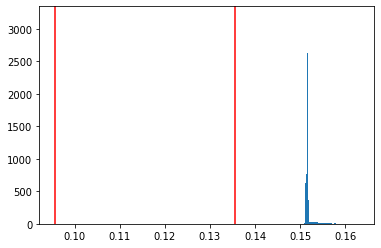

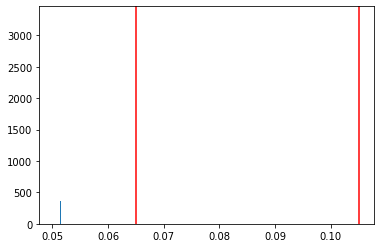

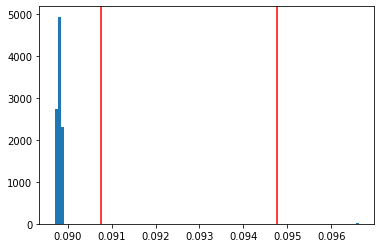

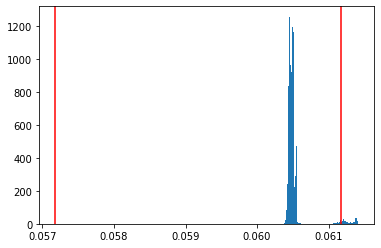

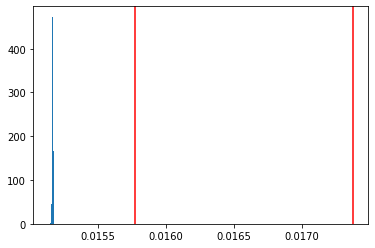

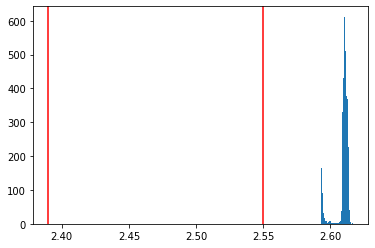

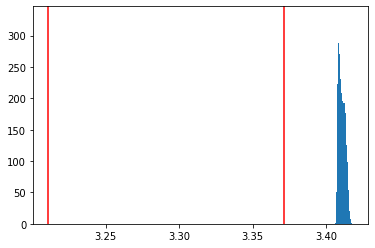

In [70]:
for dim in range(20):
    plt.hist(samples.numpy()[:, dim], bins=100)
    plt.axvline(lower_[dim], c="r")
    plt.axvline(upper_[dim], c="r")
    plt.show()

In [38]:
prior.log_prob(samples)

tensor([-inf, -inf, -inf,  ..., -inf, -inf, -inf])

In [4]:
with open("../../../arco_sims/posteriors/88_90233447606250669_samples.pickle", "wb") as handle:
    pickle.dump(samples, handle)

In [ ]:
def infer_bounds_from_solution():

In [5]:
thetas = []
xs = []

for k in range(20):

    with open(f'../../../arco_sims/simulations/{k}.pickle.hay_objectives', 'rb') as handle:
        data = pickle.load(handle)

    for t in data:
        thetas.append(t[0])
        xs.append(list(t[2].values()))

theta = torch.as_tensor(np.asarray(thetas), dtype=torch.float32)
x = torch.as_tensor(np.asarray(xs), dtype=torch.float32)

In [6]:
lower_lim, _ = torch.min(theta, dim=0)
upper_lim, _ = torch.max(theta, dim=0)

lower_lim = lower_lim.unsqueeze(0)
upper_lim = upper_lim.unsqueeze(0)

In [10]:
limits = torch.cat([lower_lim, upper_lim], dim=0).T

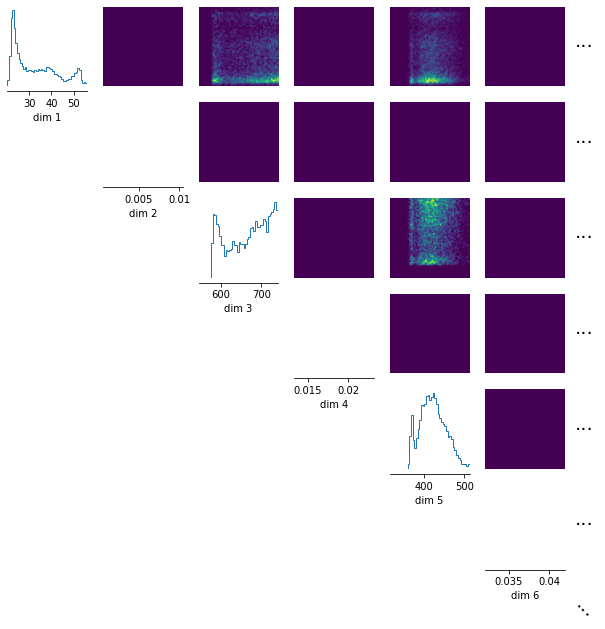

In [16]:
_ = pairplot(samples, limits=limits, subset=[0,1,2,3,4,5])

/home/michael/Documents/sbi/sbi/utils/conditional_density.py:57: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import eval_conditional_density`.
  warn(
/home/michael/Documents/sbi/sbi/utils/conditional_density.py:57: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import eval_conditional_density`.
  warn(
/home/michael/Documents/sbi/sbi/utils/conditional_density.py:57: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import eval_conditional_density`.
  warn(


(<Figure size 720x720 with 9 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>]],
       dtype=object))

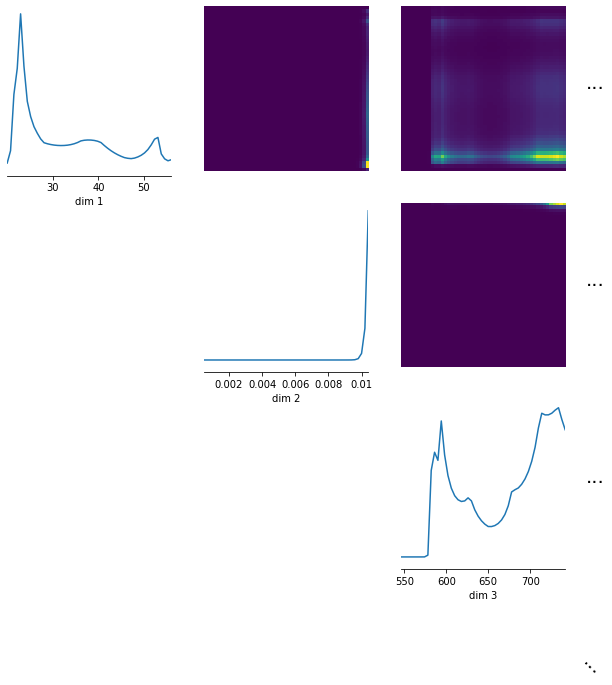

In [11]:
conditional_pairplot(posterior, limits=limits, subset=[0,1,2], condition=samples[0])

# Ignore

In [139]:
from warnings import warn
import torch

from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms
from pyknos.nflows.nn import nets
from torch import Tensor, nn, relu, tanh, optim

from sbi.utils.sbiutils import standardizing_net, standardizing_transform
from sbi.utils.torchutils import create_alternating_binary_mask

from torch.utils import data
import matplotlib.pyplot as plt

In [142]:
class my_class(nn.Module):
    def __init__(self, in_features, out_features, context_features):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(1, out_features))
        self.layer = nn.Linear(context_features, out_features)
        
    def __call__(self, inputs, context, *args, **kwargs):
        return self.layer(context)

In [143]:
from torch import tensor
from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms

In [144]:
import torch
import nflows.transforms

x_numel = 1
context_numel = 1
num_transforms = 2

transform = transforms.CompositeTransform(
        [
            transforms.CompositeTransform(
                [
                    transforms.PiecewiseRationalQuadraticCouplingTransform(
                        mask=tensor([1], dtype=torch.uint8),
                        transform_net_create_fn=lambda in_features, out_features: my_class(in_features, out_features, context_numel),
                        num_bins=10,
                        tails="linear",
                        tail_bound=5.0,
                        apply_unconditional_transform=False,
                    ),
                    transforms.LULinear(x_numel, identity_init=True),
                ]
            )
            for i in range(num_transforms)
        ]
    )

distribution = distributions_.StandardNormal((x_numel,))
neural_net = flows.Flow(transform, distribution)

In [145]:
x = torch.tensor([[2.]])
c = torch.tensor([[2.]])

output = transform(x, c)

In [146]:
output

(tensor([[4.4780]], grad_fn=<AddmmBackward>),
 tensor([-2.3386], grad_fn=<AddBackward0>))

In [147]:
theta = torch.randn(1000, 1)
x = theta + 0.1 * torch.randn(1000, 1)

dataset = data.TensorDataset(
    theta,
    x,
)

In [148]:
train_loader = data.DataLoader(
    dataset,
    batch_size=20,
    drop_last=True,
)

In [149]:
optimizer = optim.Adam(list(neural_net.parameters()), lr=1e-4)

In [150]:
for e in range(200):
    neural_net.train()
    for batch in train_loader:
        optimizer.zero_grad()
        theta_batch, x_batch = (
            batch[0],
            batch[1],
        )
        log_probs = neural_net.log_prob(theta_batch, x_batch)
        loss = -log_probs.mean()
        loss.backward()
        optimizer.step()
        
    if e % 10 == 0:
        print("finished", e)
nn = neural_net.eval()

finished 0
finished 10
finished 20
finished 30
finished 40
finished 50
finished 60
finished 70
finished 80
finished 90
finished 100
finished 110
finished 120
finished 130
finished 140
finished 150
finished 160
finished 170
finished 180
finished 190


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   7., 235., 184., 266., 157., 119.,  25.,
          7.,   0.,   0.,   0.,   0.,   0.]),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,
         2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ], dtype=float32),
 <BarContainer object of 50 artists>)

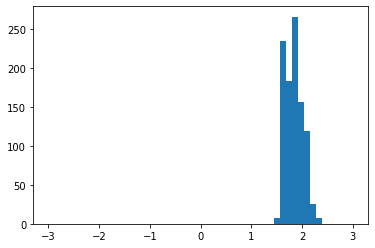

In [153]:
samples = neural_net.sample(1000, torch.tensor([[2.0]]))
plt.hist(samples.detach().numpy()[0, :, 0], bins=50, range=[-3, 3])

(array([  0.,   0.,   0.,   0.,   0.,   1.,  20., 113., 413., 364.,  84.,
          3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,
         2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ], dtype=float32),
 <BarContainer object of 50 artists>)

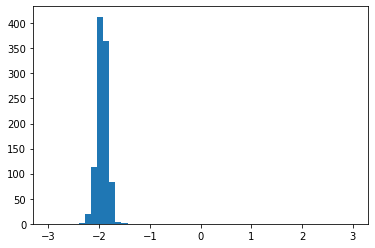

In [155]:
samples = neural_net.sample(1000, torch.tensor([[-2.0]]))
plt.hist(samples.detach().numpy()[0, :, 0], bins=50, range=[-3, 3])